In [2]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

19828


In [3]:
save_folder = r'\\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
print(len(save_filenames))
segmentation_folder = os.path.join(save_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
cand_spots_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spots_folder):
    os.makedirs(cand_spots_folder)

42


In [4]:
figure_folder = os.path.join(save_folder, 'Figures')
if not os.path.exists(figure_folder):
    print(f"Create figure_folder: {figure_folder}")
    os.makedirs(figure_folder)
else:
    print(f"Use figure_folder: {figure_folder}")
    
cand_spot_folder = os.path.join(save_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

Use figure_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\Figures
Use cand_spot_folder: \\mendel\Mendel_SSD2\Pu_Temp\20211108-P_brain_CTP11-1000_DNA_only\CandSpots


## load codebook

In [8]:
import pandas as pd
codebook_filename = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\CTP-11_brain\Summary_tables\CTP11-mouse-genome-1000_codebook.csv'
#
codebook_df = pd.read_csv(codebook_filename, header=0)
codebook_df

name    id  NDB_784  NDB_755  NDB_826  NDB_713  NDB_865  \
0        1:3740000-3760000     1        0        0        0        0        0   
1        1:6240000-6260000     2        0        0        0        0        0   
2        1:8740000-8760000     3        0        0        0        0        0   
3      1:11240000-11260000     4        0        0        0        0        0   
4      1:13740000-13760000     5        0        0        0        0        0   
..                     ...   ...      ...      ...      ...      ...      ...   
983  X:161240000-161260000  1057        0        0        1        0        0   
984  X:163740000-163760000  1058        0        0        0        0        0   
985  X:166240000-166260000  1059        0        0        0        0        0   
986  X:168740000-168760000  1060        0        0        0        0        0   
987      Y:1240000-1260000  1062        0        0        0        0        0   

     NDB_725  NDB_817  NDB_710  ...  NDB_824  NDB_712  NDB_818  NDB_940  \
0          0        0        0  ...        0        0        0        0   
1          0        0        0  ...        0        0        0        0   
2          0        0        0  ...        0        0        0        0   
3          0        0        0  ...        0        0        0        1   
4          0        0        0  ...        0        0        1        0   
..       ...      ...      ...  ...      ...      ...      ...      ...   
983        0        0        0  ...        0        0        0        0   
984        0        0        0  ...        0        0        0        0   
985        1        0        0  ...        0        0        0        0   
986        0        0        0  ...        0        0        0        0   
987        0        0        1  ...        0        0        0        0   

     NDB_872  NDB_934  NDB_926  NDB_910  chr  chr_order  
0          0        0        0        0    1          0  
1          0        0        0        0    1          1  
2          0        0        0        0    1          2  
3          0        0        0        0    1          3  
4          0        0        0        0    1          4  
..       ...      ...      ...      ...  ...        ...  
983        0        1        0        0    X         52  
984        1        0        0        0    X         53  
985        0        0        0        0    X         54  
986        0        0        0        0    X         55  
987        0        0        0        0    Y          0  

[988 rows x 103 columns]

In [9]:
_ordered_chr_names = []
for _chr_name, _chr_reg_id in zip(codebook_df['chr'], codebook_df['chr_order']):
    if _chr_name not in _ordered_chr_names:
        _ordered_chr_names.append(_chr_name)
chr_2_indices = {_chr:np.array(codebook_df.loc[codebook_df['chr']==_chr].index)
                for _chr in np.unique(codebook_df['chr'].values)}

_labels_edges = np.array([0] + [np.max(chr_2_indices[_chr]) for _chr in _ordered_chr_names])

## spots

In [10]:
spot_filenames = [os.path.join(cand_spot_folder, _fl) for _fl in os.listdir(cand_spot_folder)]
print(len(spot_filenames))

1944


In [11]:
cand_cell_dict = pickle.load(open(spot_filenames[-1], 'rb'))
cand_cell_dict.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [12]:
import multiprocessing as mp
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [13]:
from ImageAnalysis3.classes.preprocess import Spots3D

In [ ]:
%%time
import multiprocessing as mp
from ImageAnalysis3.classes import decode
reload(decode)
overwrite = True

decode_args = [(_fl, codebook_df, None, pixel_sizes, 2, 0.5, 
                200, -1, 1, 5, 0, -25, False, overwrite) for _fl in spot_filenames[:]
               #if not os.path.exists(_fl.replace('CandSpots', 'Decoder'))
              ]
print(len(decode_args))

with mp.Pool(44) as decode_pool:
    decode_results = decode_pool.starmap(decode.batch_decode_DNA, decode_args[:], chunksize=1)
    decode_pool.close()
    decode_pool.join()
    decode_pool.terminate()

1794


## load decode results

In [5]:
decode_folder = os.path.join(save_folder, 'Decoder')

decode_files = [os.path.join(decode_folder, _fl) for _fl in os.listdir(decode_folder) 
                if _fl.split(os.path.extsep)[-1]=='pkl']
print(len(decode_files))

705


In [47]:
%%time
import multiprocessing as mp
load_args = [(_fl, 'chr_2_zxys_list') for _fl in decode_files[:]]
print(len(load_args))
with mp.Pool(44) as load_pool:
    all_chr_2_zxys_list = load_pool.starmap(decode.batch_load_attr, 
                                            load_args, chunksize=1)
    load_pool.close()
    load_pool.join()
    load_pool.terminate()

all_chr_2_zxys_list = [_item for _item in all_chr_2_zxys_list if _item is not None]
print(len(all_chr_2_zxys_list))

245
245
Wall time: 12.1 s


In [48]:
%%time
import multiprocessing as mp

summary_args = [(_item, codebook_df) for _item in all_chr_2_zxys_list ]

with mp.Pool(44) as summary_pool:
    all_zxys_list = summary_pool.starmap(decode.DNA_Merfish_Decoder.summarize_zxys_by_regions, 
                                         summary_args, chunksize=1)
    summary_pool.close()
    summary_pool.join()
    summary_pool.terminate()

Wall time: 37.8 s


## Median distance map

In [49]:
%%time
from scipy.spatial.distance import cdist,pdist,squareform
from tqdm import tqdm

all_zxys_list = np.concatenate(all_zxys_list)

all_distmaps = [squareform(pdist(_zxys)) for _zxys in tqdm(all_zxys_list)]

from ImageAnalysis3.classes import postanalysis
median_distmap = postanalysis.parallel_reduce_matrix(all_distmaps, function='nanmedian', axis=0,
                                                     num_threads=44)

100%|████████████████████████████████████████████████████████████████████████████████| 490/490 [00:11<00:00, 42.15it/s]


Wall time: 39.5 s


In [119]:
all_contactmaps = np.array(all_distmaps) <= 1

In [120]:
contactmap = postanalysis.parallel_reduce_matrix(all_contactmaps, function='nanmean', axis=0,
                                                     num_threads=44)

<IPython.core.display.Javascript object>


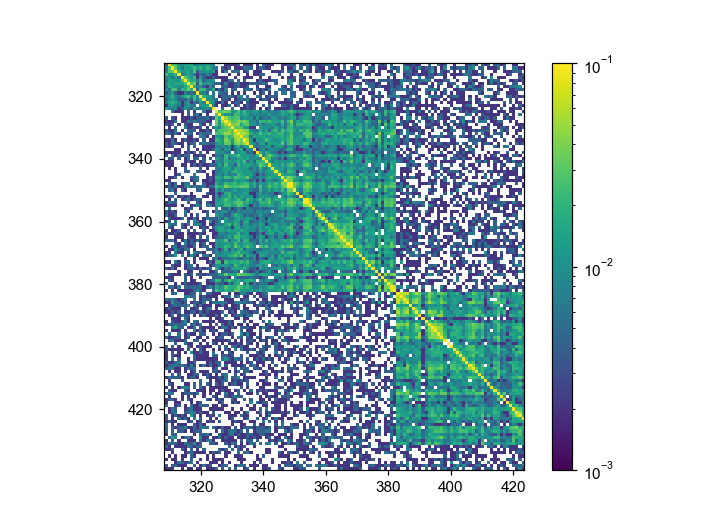

In [125]:
from matplotlib.colors import LogNorm
plt.figure()
plt.imshow(contactmap, norm=LogNorm(vmin=0.001, vmax=0.1) )
plt.colorbar()

<IPython.core.display.Javascript object>


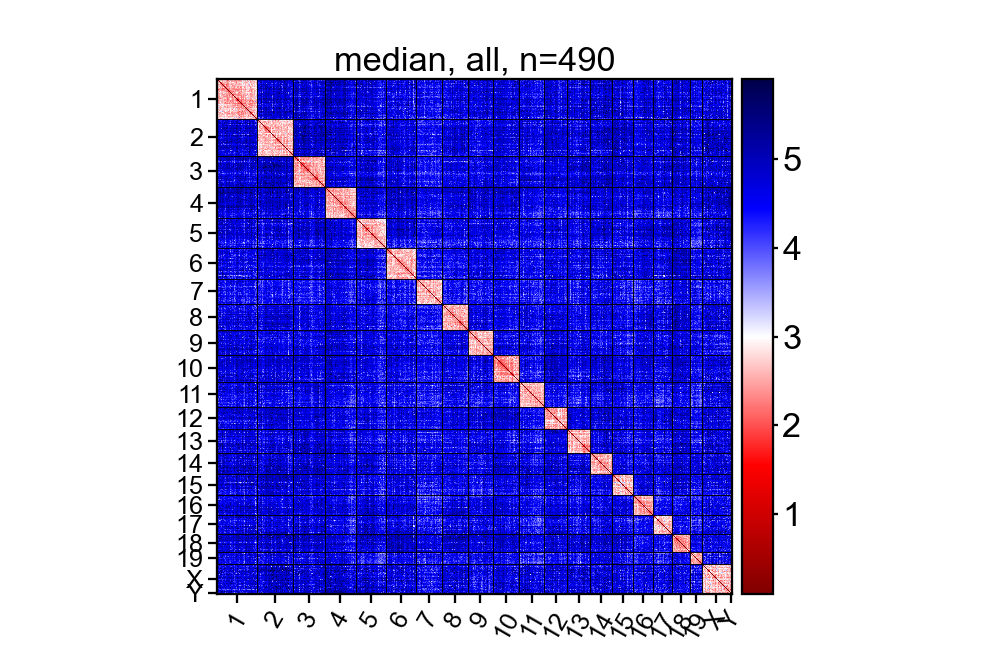

In [57]:
%matplotlib notebook

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

ia.figure_tools.distmap.plot_distance_map(median_distmap, color_limits=[0.1,5.9],
                                          ax=ax,
                                          )
ax.set_title(f'median, all, n={len(all_distmaps)}', fontsize=7.5, pad=2)

ax.set_xticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_xticklabels(_ordered_chr_names, fontsize=5.5, rotation=60,)
ax.set_yticks((_labels_edges[1:] + _labels_edges[:-1])/2)
ax.set_yticklabels(_ordered_chr_names, fontsize=5.5, )

ax.hlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)
ax.vlines(_labels_edges, 0, len(median_distmap), color='black', linewidth=0.2)

plt.gcf().subplots_adjust(bottom=0.1, left=0.1, right=0.9,)

fig.savefig(os.path.join(figure_folder, 'all_median_distmap.png'), transparent=True)
fig.show()

## Test parameaters

In [14]:
import multiprocessing as mp
from ImageAnalysis3.classes import decode
reload(decode)

<module 'ImageAnalysis3.classes.decode' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\classes\\decode.py'>

In [15]:
cand_spots = decode.spots_dict_to_cand_spots(spot_filenames[1])
pixel_sizes = [250,108,108]

decoder = decode.DNA_Merfish_Decoder(codebook_df, cand_spots,
                              pixel_sizes=pixel_sizes, valid_score_th=-25,
                              savefile=spot_filenames[1].replace('CandSpots','Decoder'),
                              ct_dist_factor=5, local_dist_factor=0,
                              load_from_file=False,
                              )

4925 pairs kept given search radius 200 nm.


4925it [00:06, 742.00it/s]


- 2981 spot groups selected. 


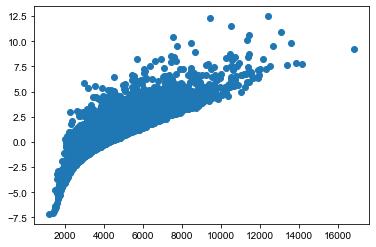

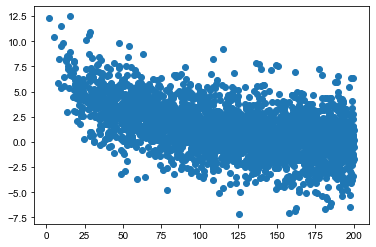

-- seeding chr:1 with 77 regions with 102 spot_groups
- diff in iter-0: 0.6471
- diff in iter-1: 0.0196
- diff in iter-2: 0.0098
- diff in iter-3: 0.0196
- diff in iter-4: 0.0196
- diff in iter-5: 0.0196
- diff in iter-6: 0.0196
- diff in iter-7: 0.0098
- diff in iter-8: 0.0000
-- seeding chr:10 with 51 regions with 68 spot_groups
- diff in iter-0: 0.7059
- diff in iter-1: 0.0588
- diff in iter-2: 0.0294
- diff in iter-3: 0.0147
- diff in iter-4: 0.0294
- diff in iter-5: 0.0000
-- seeding chr:11 with 48 regions with 64 spot_groups
- diff in iter-0: 0.8125
- diff in iter-1: 0.0156
- diff in iter-2: 0.0156
- diff in iter-3: 0.0000
-- seeding chr:12 with 43 regions with 51 spot_groups
- diff in iter-0: 0.7255
- diff in iter-1: 0.0980
- diff in iter-2: 0.0000
-- seeding chr:13 with 45 regions with 62 spot_groups
- diff in iter-0: 0.7097
- diff in iter-1: 0.1290
- diff in iter-2: 0.0484
- diff in iter-3: 0.0323
- diff in iter-4: 0.0000
-- seeding chr:14 with 42 regions with 70 spot_groups
-

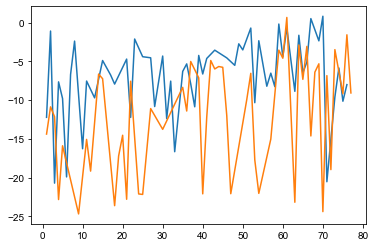

- diff in iter-1: 0.0489


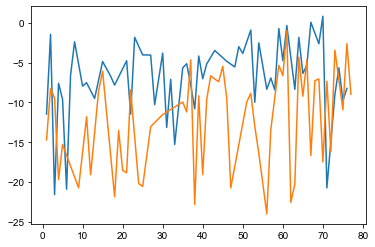

- diff in iter-2: 0.0222


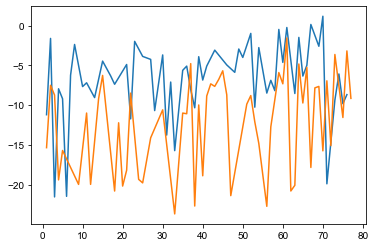

- diff in iter-3: 0.0000


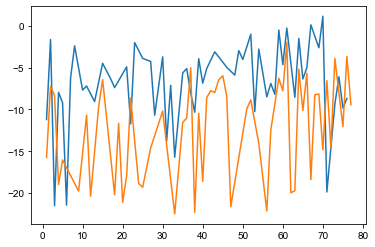

- processing chr:10
- diff in iter-0: 0.4516


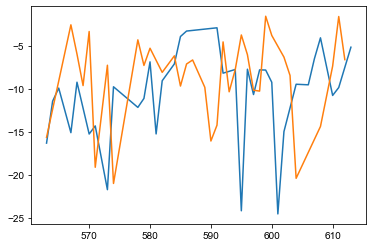

- diff in iter-1: 0.0323


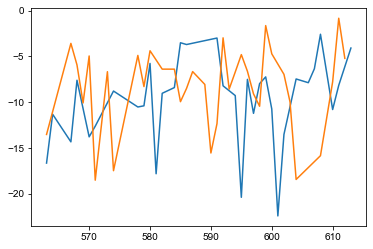

- diff in iter-2: 0.0194


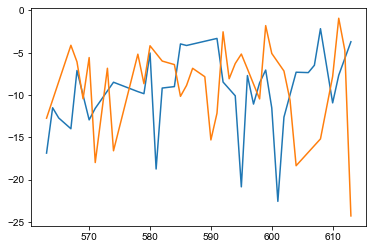

- diff in iter-3: 0.0000


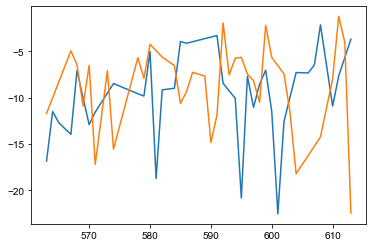

- processing chr:11
- diff in iter-0: 0.5000


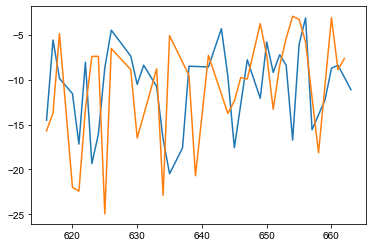

- diff in iter-1: 0.0857


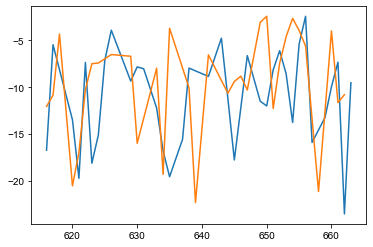

- diff in iter-2: 0.0143


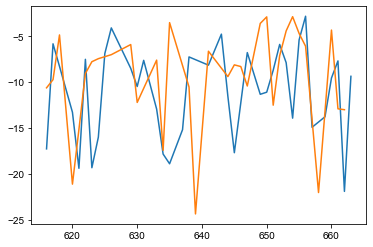

- diff in iter-3: 0.0000


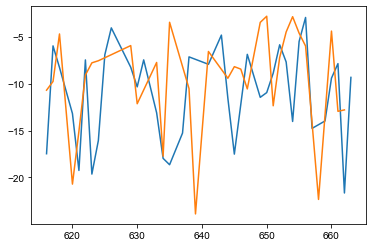

- processing chr:12
- diff in iter-0: 0.4545


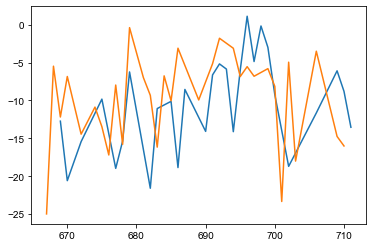

- diff in iter-1: 0.0379


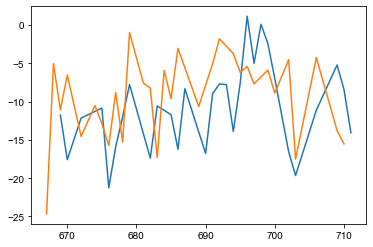

- diff in iter-2: 0.0000


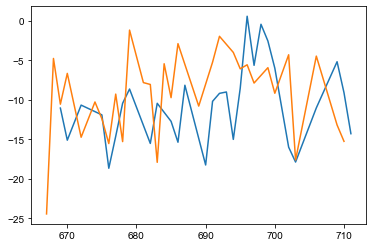

- processing chr:13
- diff in iter-0: 0.5185


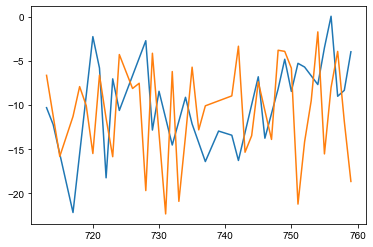

- diff in iter-1: 0.0667


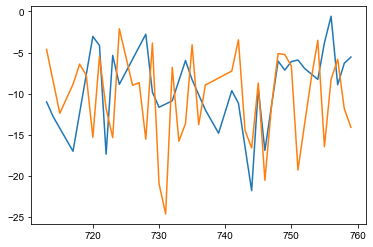

- diff in iter-2: 0.0222


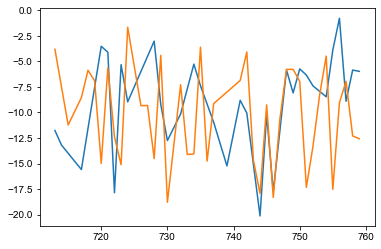

- diff in iter-3: 0.0000


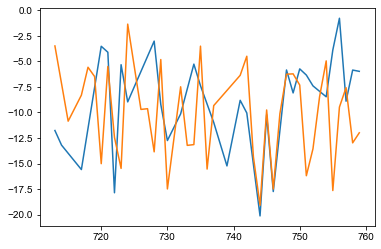

- processing chr:14
- diff in iter-0: 0.4701


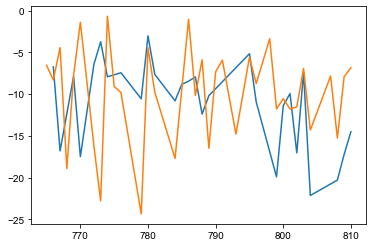

- diff in iter-1: 0.0821


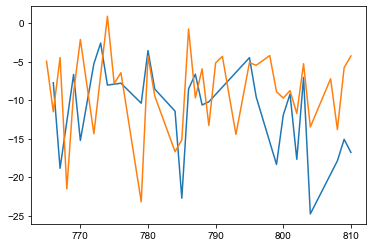

- diff in iter-2: 0.0373


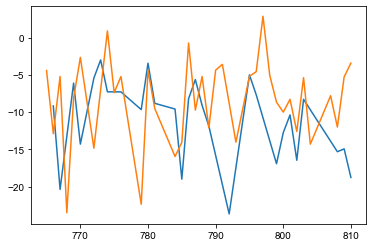

- diff in iter-3: 0.0000


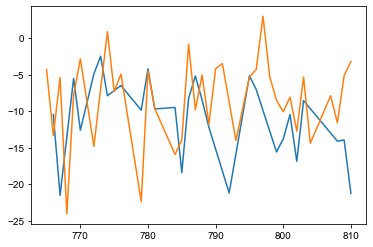

- processing chr:15
- diff in iter-0: 0.4667


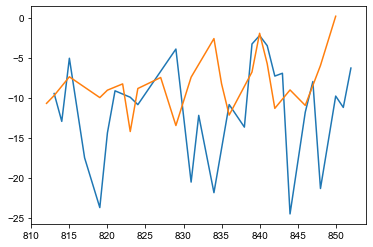

- diff in iter-1: 0.0286


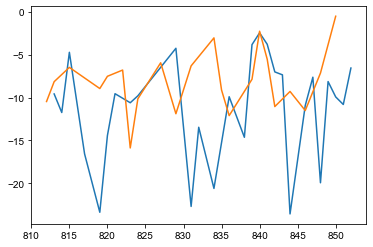

- diff in iter-2: 0.0000


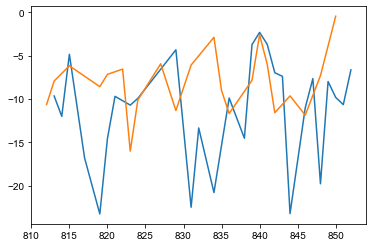

- processing chr:16
- diff in iter-0: 0.4453


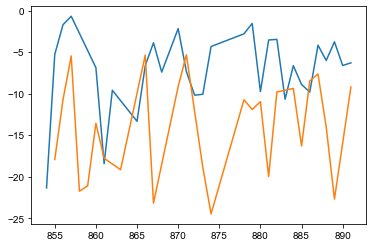

- diff in iter-1: 0.0547


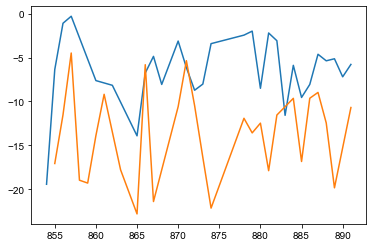

- diff in iter-2: 0.0469


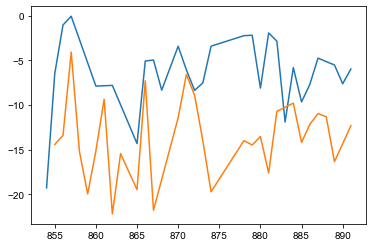

- diff in iter-3: 0.0078


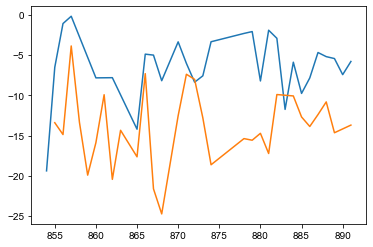

- diff in iter-4: 0.0000


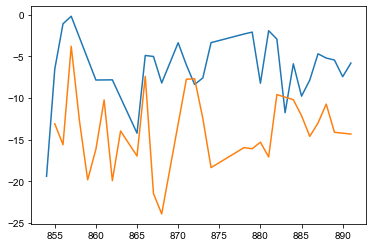

- processing chr:17
- diff in iter-0: 0.4915


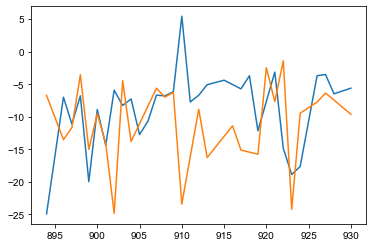

- diff in iter-1: 0.0254


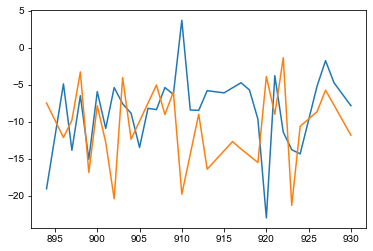

- diff in iter-2: 0.0169


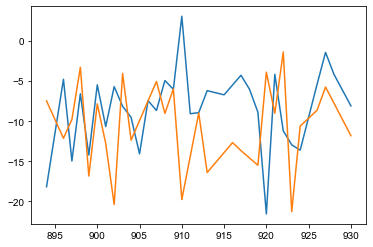

- diff in iter-3: 0.0000


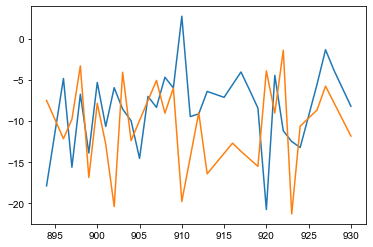

- processing chr:18
- diff in iter-0: 0.4390


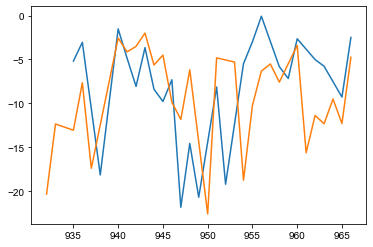

- diff in iter-1: 0.0325


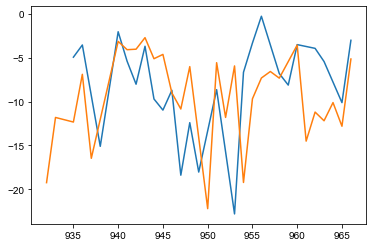

- diff in iter-2: 0.0488


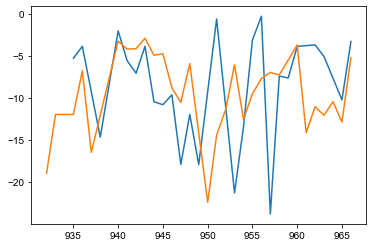

- diff in iter-3: 0.0407


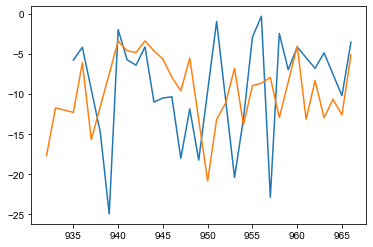

- diff in iter-4: 0.0325


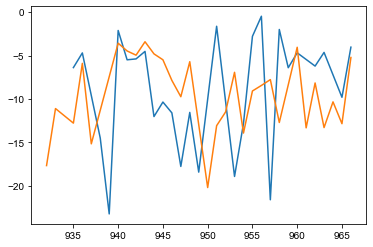

- diff in iter-5: 0.0000


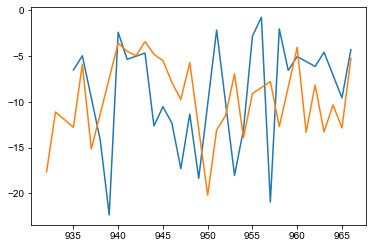

- processing chr:19
- diff in iter-0: 0.4286


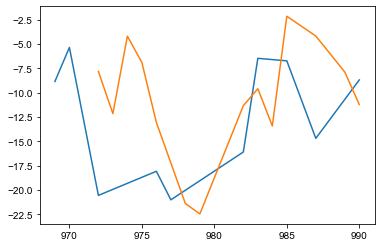

- diff in iter-1: 0.1786


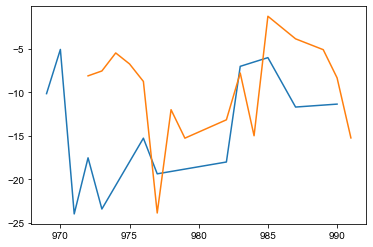

- diff in iter-2: 0.0000


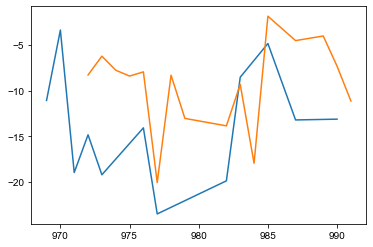

- processing chr:2
- diff in iter-0: 0.4883


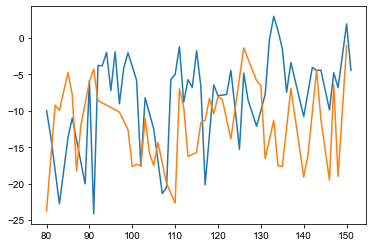

- diff in iter-1: 0.0704


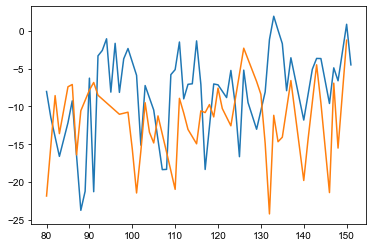

- diff in iter-2: 0.0094


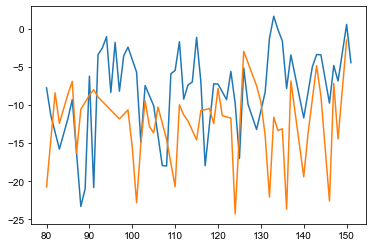

- diff in iter-3: 0.0094


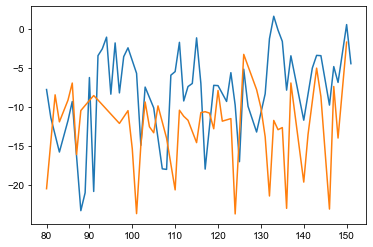

- diff in iter-4: 0.0188


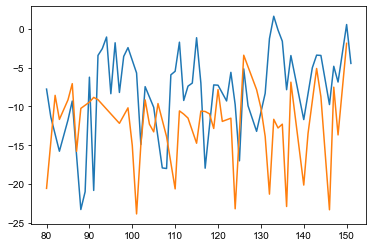

- diff in iter-5: 0.0047


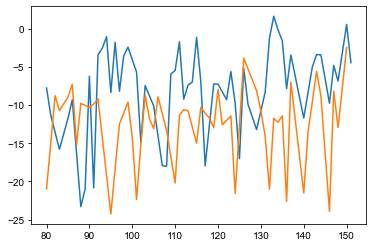

- diff in iter-6: 0.0000


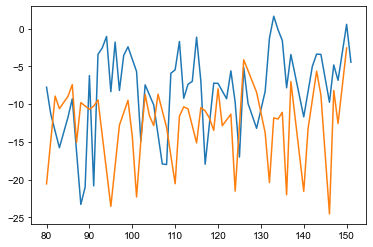

- processing chr:3
- diff in iter-0: 0.4421


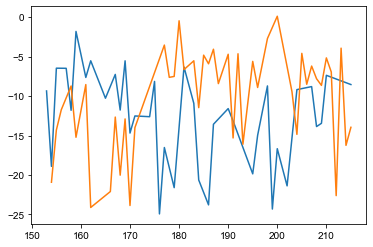

- diff in iter-1: 0.0526


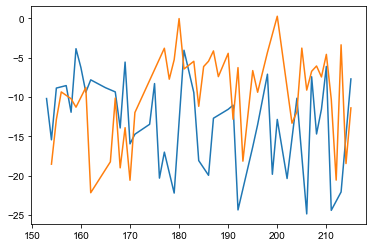

- diff in iter-2: 0.0053


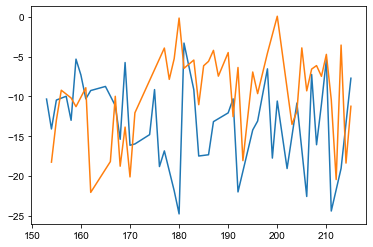

- diff in iter-3: 0.0000


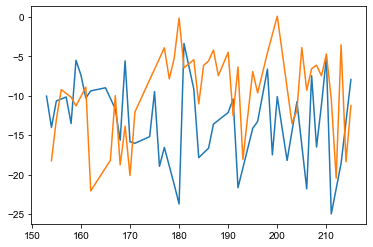

- processing chr:4
- diff in iter-0: 0.5380


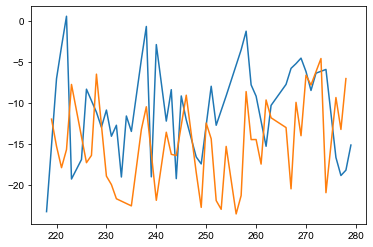

- diff in iter-1: 0.0760


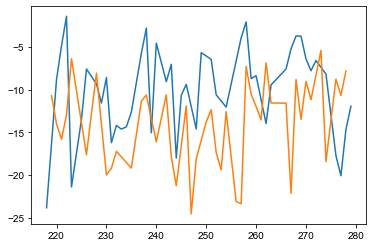

- diff in iter-2: 0.0526


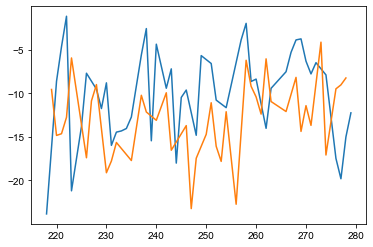

- diff in iter-3: 0.0351


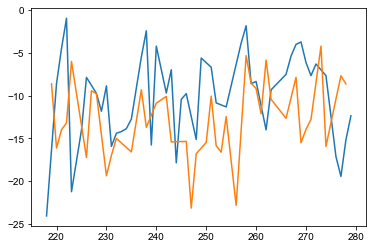

- diff in iter-4: 0.0058


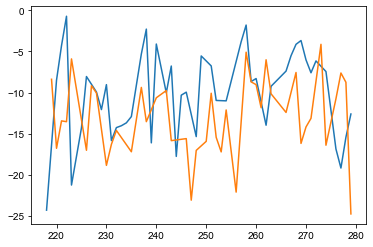

- diff in iter-5: 0.0000


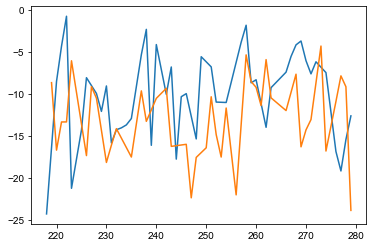

- processing chr:5
- diff in iter-0: 0.5148


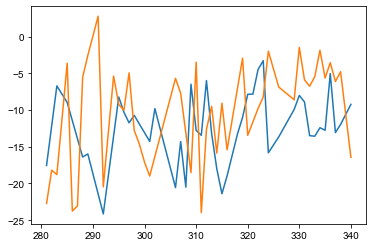

- diff in iter-1: 0.0118


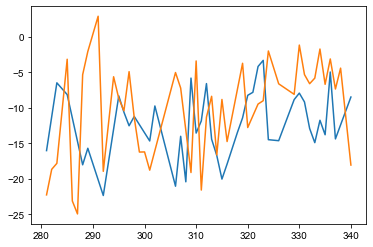

- diff in iter-2: 0.0000


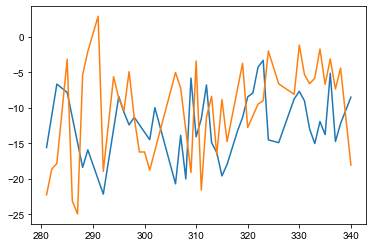

- processing chr:6
- diff in iter-0: 0.4333


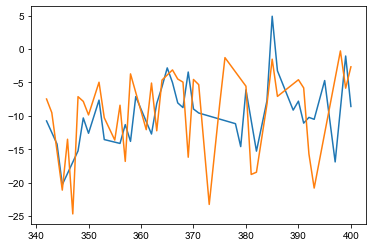

- diff in iter-1: 0.0278


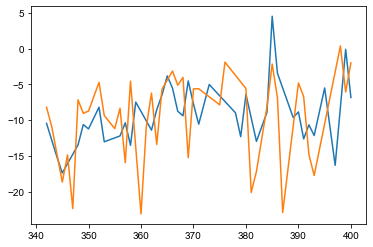

- diff in iter-2: 0.0111


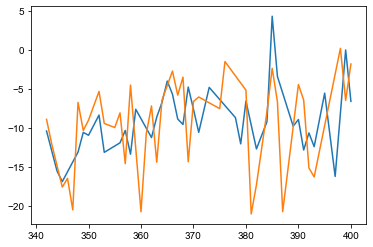

- diff in iter-3: 0.0000


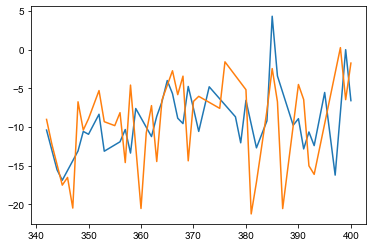

- processing chr:7
- diff in iter-0: 0.5432


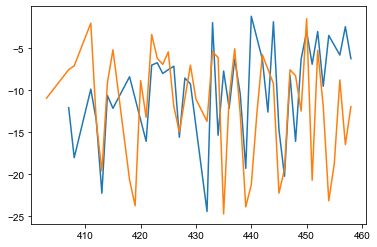

- diff in iter-1: 0.0432


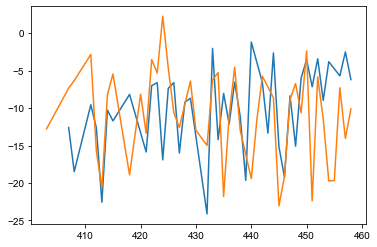

- diff in iter-2: 0.0247


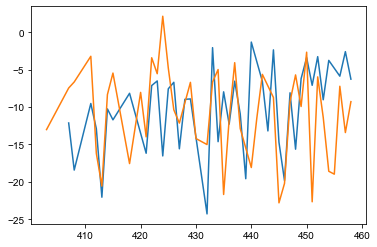

- diff in iter-3: 0.0309


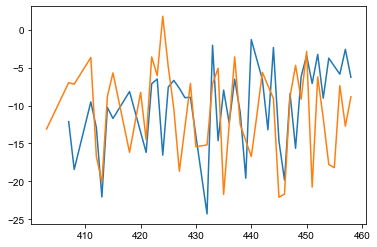

- diff in iter-4: 0.0309


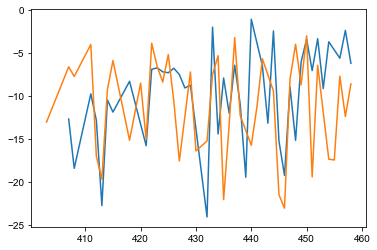

- diff in iter-5: 0.0000


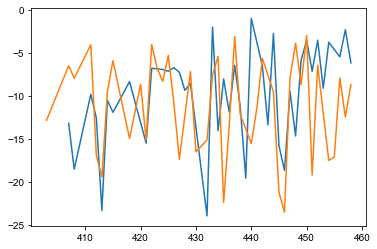

- processing chr:8
- diff in iter-0: 0.5238


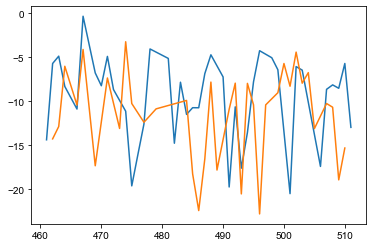

- diff in iter-1: 0.0136


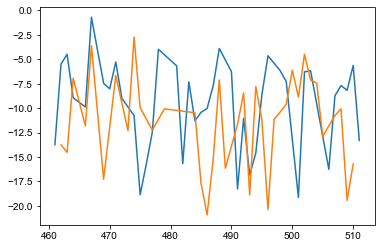

- diff in iter-2: 0.0000


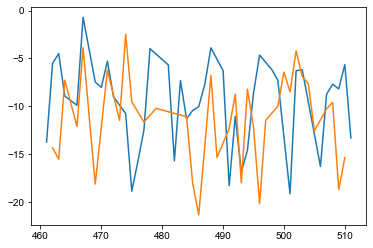

- processing chr:9
- diff in iter-0: 0.4514


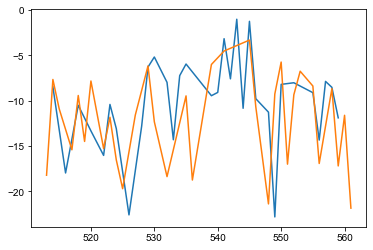

- diff in iter-1: 0.0625


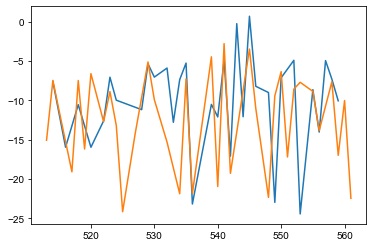

- diff in iter-2: 0.0278


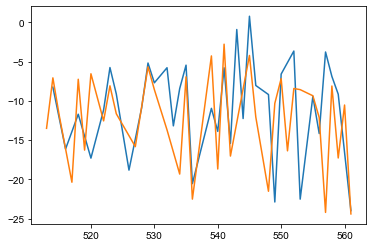

- diff in iter-3: 0.0069


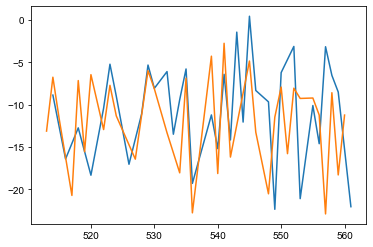

- diff in iter-4: 0.0069


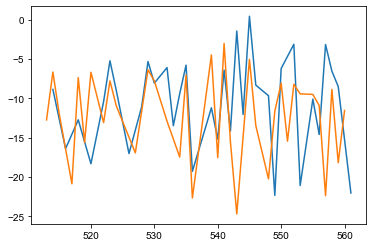

- diff in iter-5: 0.0000


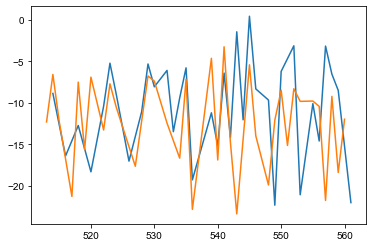

- processing chr:X
- diff in iter-0: 0.5197


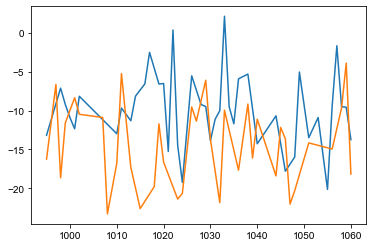

- diff in iter-1: 0.0526


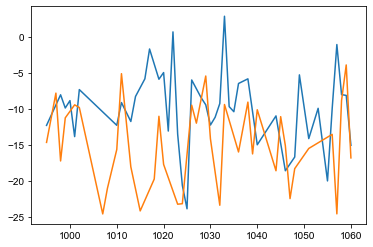

- diff in iter-2: 0.0132


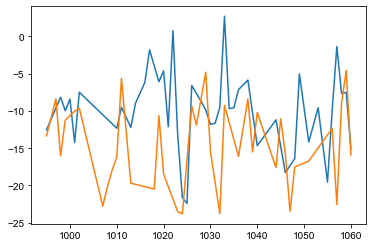

- diff in iter-3: 0.0197


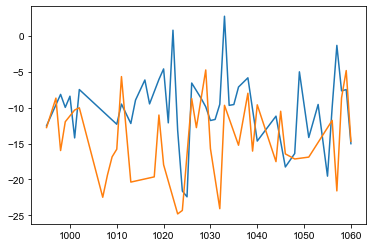

- diff in iter-4: 0.0197


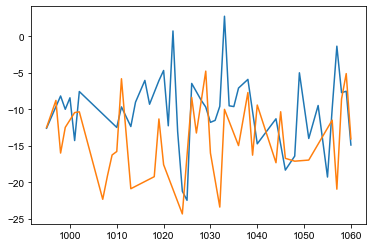

- diff in iter-5: 0.0263


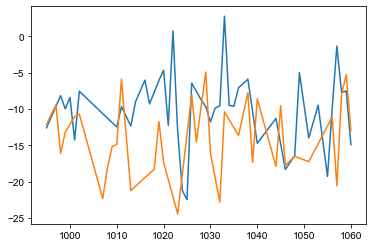

- diff in iter-6: 0.0000


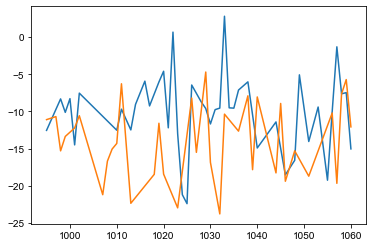

In [16]:
%matplotlib inline
_overwrite = True
pair_search_radius = 200

decoder.prepare_spot_tuples(pair_search_radius=pair_search_radius, overwrite=_overwrite)

self_scores = decoder.calculate_self_scores(make_plots=True, overwrite=_overwrite)

chrs_2_init_centers = decoder.init_homolog_assignment(min_cand_number=10, overwrite=_overwrite)

chr_2_assigned_tuple_list, chr_2_zxys_list, chr_2_chr_centers= \
    decoder.finish_homolog_assignment(plot_stats=True, overwrite=_overwrite, verbose=True)

<IPython.core.display.Javascript object>


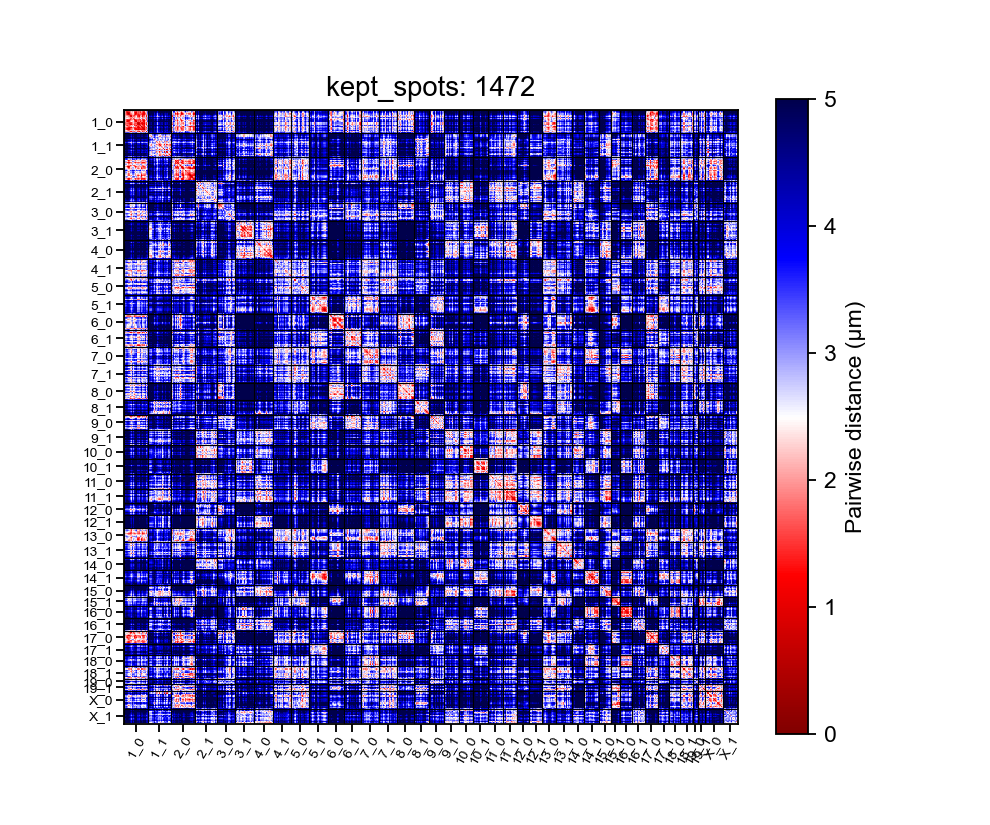

In [17]:
%matplotlib notebook
figure_zxys_list, figure_labels, figure_label_ids = decoder.summarize_zxys_all_chromosomes()

# distmap
#distmap_filename = decoder_filename.replace('Decoder.pkl', 'AllDistmap.png')
_ax = decoder.summarize_to_distmap(decoder, color_limits=[0,5])#, save_filename=distmap_filename) 

In [ ]:
def find_prev_neighbors(_cand_tuples_list, _ireg, _reverse=True):
    """Function to find the nearest neighbor"""
    for _i in range
    
    

In [18]:
_chr_name = '1'
_chr_tuples = [_g for _g in decoder.spot_groups if _g.chr==_chr_name]

In [19]:
_chr_region_ids = decoder.extract_chr_region_ids(decoder.codebook, _chr_name)

In [22]:
from scipy.spatial.distance import cdist

In [28]:
_ireg = 10
# distribute tuples into region_ids
_cand_tuples_list = [[_g for _g in _chr_tuples if _g.chr_order==_i] 
                    for _i in np.arange(0, np.max(_chr_region_ids)+1)]

_cand_zxys_list = [decoder.tuple_list_to_zxys(_tps) for _tps in _cand_tuples_list]

_reverse=True

print(_ireg, len(_cand_zxys_list[_ireg]))

if _reverse:
    for _jreg in np.flipud(np.arange(0, _ireg)):
        if len(_cand_tuples_list[_jreg]) > 0:
            print(_jreg, len(_cand_tuples_list[_jreg]))
            
            # calculate distances
            _nb_dists = cdist(_cand_zxys_list[_ireg], _cand_zxys_list[_jreg])
        break
            


10 3
9 3


In [29]:
from ImageAnalysis3.spot_tools.scoring import log_distance_scores, exp_distance_scores

In [30]:
_jreg

9

In [31]:
_cand_tuples_list[_jreg]

In [32]:
[_g.homolog for _g in _cand_tuples_list[_jreg]]

[0, -1, -1]

In [177]:
np.max(exp_distance_scores(_nb_dists))

-19.267039797972792

In [131]:
(_cand_zxys_list)

[array([[  5351.0184288 , 213440.12841797, 140130.29003906],
        [  5828.45211029, 216813.45410156, 138518.72753906],
        [  5031.97431564, 218122.17626953, 141553.35351562],
        [  9267.89569855, 216780.93017578, 137813.55029297],
        [  5910.76135635, 212532.66210938, 137675.47851562],
        [ 10482.28263855, 216328.91748047, 138213.79101562]]),
 array([[  4671.77724838, 216161.27490234, 140475.06738281],
        [  5910.14480591, 214525.91601562, 139417.62451172],
        [  8335.59989929, 212789.42578125, 137724.99609375]]),
 array([[  9939.75830078, 213172.15869141, 138930.08203125],
        [  7688.73071671, 213902.37158203, 138050.18261719],
        [  6288.54656219, 213287.42285156, 136733.43164062],
        [  3373.63600731, 213490.92480469, 139592.25439453],
        [  8339.10751343, 214863.02050781, 136301.03613281],
        [  4899.43218231, 215895.375     , 138354.51269531]]),
 array([[  4303.7276268 , 215900.14746094, 138195.55810547],
        [  6078.34

In [202]:
_dists = pdist(np.concatenate(figure_zxys_list))
plt.figure()
plt.hist(_dists, bins=np.arange(0,10,0.1))
plt.title(f"median:{np.median(_dists):.3f}")
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


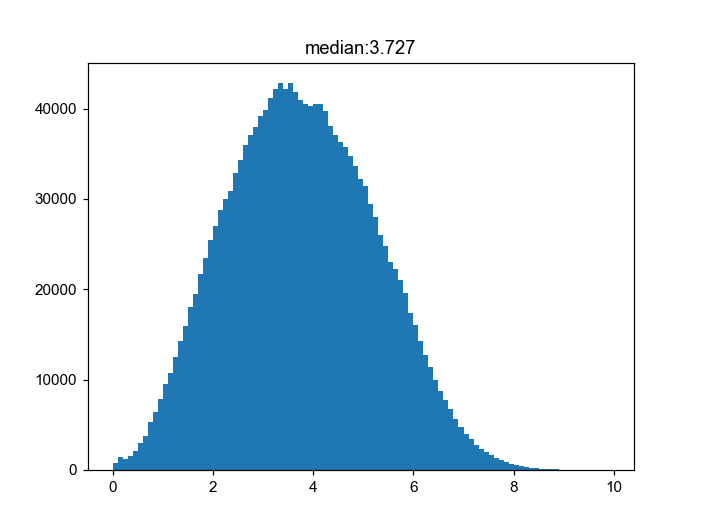

In [78]:
_dists = pdist(np.concatenate(figure_zxys_list))
plt.figure()
plt.hist(_dists, bins=np.arange(0,10,0.1))
plt.title(f"median:{np.median(_dists):.3f}")
plt.show()

<IPython.core.display.Javascript object>


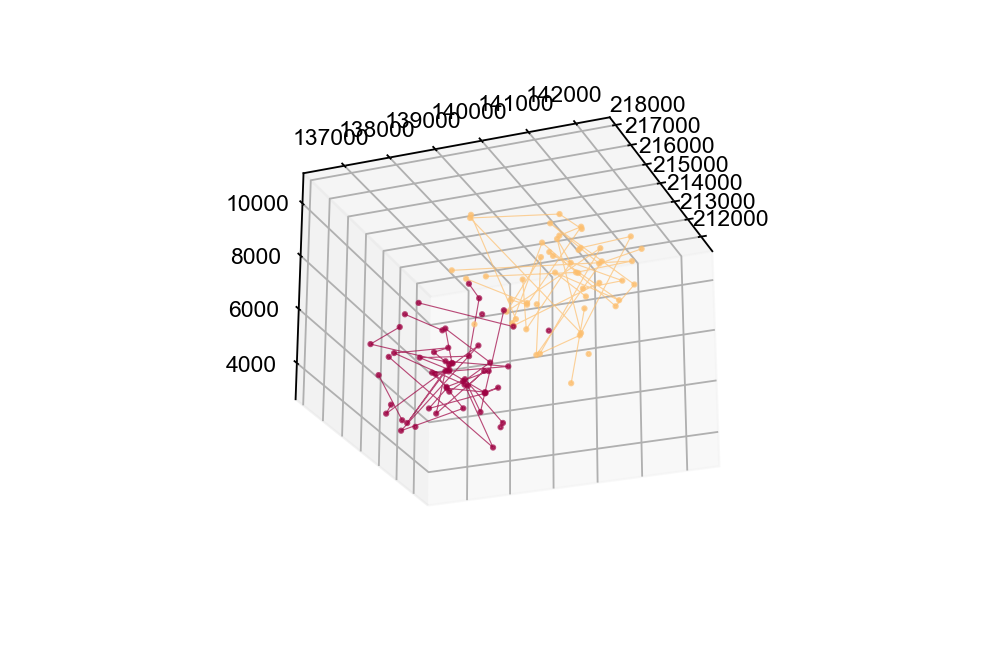

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


In [204]:
%matplotlib notebook
def rotate(angle):
     ax.view_init(azim=angle)
        
from matplotlib import animation

from matplotlib.cm import Reds, Blues, Spectral
fig = plt.figure(dpi=150)
ax = fig.add_subplot(projection='3d')

_zxys_list = decoder.chr_2_zxys_list['2']

for _ichr, _zxys in enumerate(_zxys_list):
    
    ax.scatter(_zxys[:,1], _zxys[:,2], _zxys[:,0],
               cmap=Spectral, 
               c=Spectral(_ichr/(len(_zxys_list)+1)),
               #c=homolog_labels,
               alpha=0.7,
               s=3)

    ax.plot(_zxys[:,1], _zxys[:,2], _zxys[:,0], linewidth=0.5,
            alpha=0.7,
            color = Spectral( _ichr/(len(_zxys_list)+1) ) )
    
plt.show()